In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_4378.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_747.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_561.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_345.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3019.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_2566.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3156.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3889.jpg
/kaggle/input/human-action-recognition-har-dataset

# 1| what is HAR
* Human activity recognition, or HAR for short, is a broad field of study concerned with identifying the specific movement or action of a person based on sensor data.
* Movements are often typical activities performed indoors, such as walking, talking, standing, and sitting


# Why it is important ?
* Human activity recognition plays a significant role in human-to-human interaction and interpersonal relations.
* Because it provides information about the identity of a person, their personality, and psychological state, it is difficult to extract.
* The human ability to recognize another person’s activities is one of the main subjects of study of the scientific areas of computer vision and machine learning. As a result of this research, many applications, including video surveillance systems, human-computer interaction, and robotics for human behavior characterization, require a multiple activity recognition system.

# 2| Importing libraries

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print('Mixed precision policy:', mixed_precision.global_policy())
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mixed precision policy: <Policy "mixed_float16">


# 3| Getting the path and Loading the data

In [3]:
train_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")
test_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")

In [4]:
train_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/train/*") 
test_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/test/*")

In [5]:
train_data

filename               label
0          Image_1.jpg             sitting
1          Image_2.jpg        using_laptop
2          Image_3.jpg             hugging
3          Image_4.jpg            sleeping
4          Image_5.jpg        using_laptop
...                ...                 ...
12595  Image_12596.jpg             sitting
12596  Image_12597.jpg            clapping
12597  Image_12598.jpg             sitting
12598  Image_12599.jpg             dancing
12599  Image_12600.jpg  listening_to_music

[12600 rows x 2 columns]

In [6]:
train_data.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [7]:
len(train_data.label.unique())

15

In [8]:
import plotly.express as px
HAR = train_data.label.value_counts()
fig = px.pie(train_data, values=HAR.values, names=HAR.index, title='Distribution of Human Activity')
fig.show()

In [9]:
filename = train_data['filename']

situation = train_data['label']

In [10]:
filename

0            Image_1.jpg
1            Image_2.jpg
2            Image_3.jpg
3            Image_4.jpg
4            Image_5.jpg
              ...       
12595    Image_12596.jpg
12596    Image_12597.jpg
12597    Image_12598.jpg
12598    Image_12599.jpg
12599    Image_12600.jpg
Name: filename, Length: 12600, dtype: object

# 4| Making function that take random path and display the image

In [11]:
def displaying_random_images():
    num = random.randint(1,10000)
    imgg = "Image_{}.jpg".format(num)
    train = "../input/human-action-recognition-har-dataset/Human Action Recognition/train/"
    if os.path.exists(train+imgg):
        testImage = img.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_data.loc[train_data['filename'] == "{}".format(imgg), 'label'].item()))

    else:
        #print(train+img)
        print("File Path not found \nSkipping the file!!")

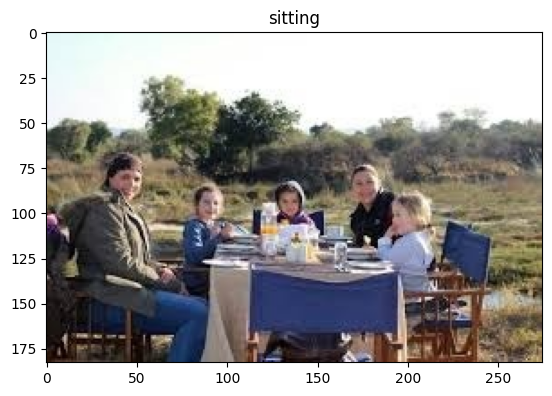

In [12]:
displaying_random_images()

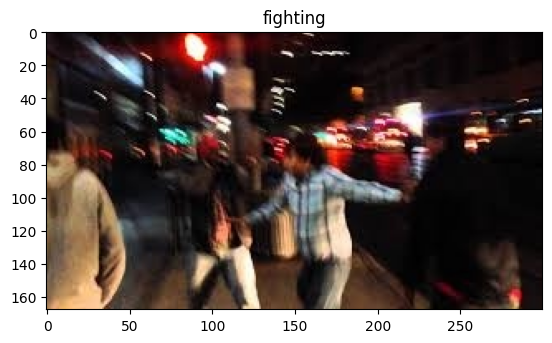

In [13]:
displaying_random_images()

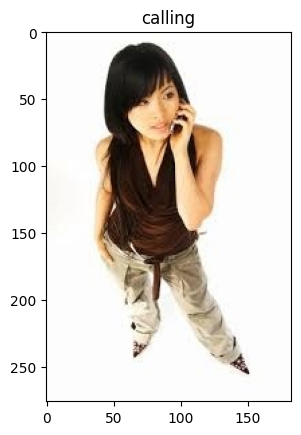

In [14]:
displaying_random_images()

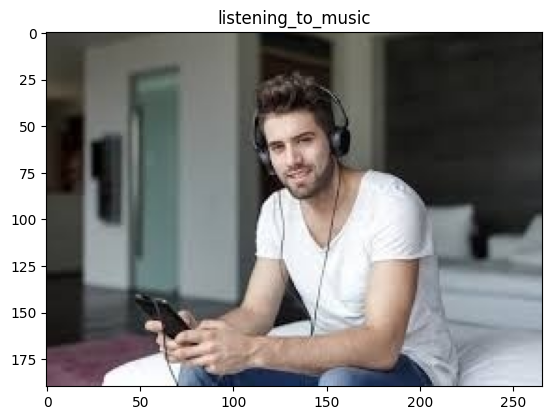

In [15]:
displaying_random_images()

# 5| Data preprocessing

In [16]:
# Configuration
SEED = 42
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

base_train_dir = "../input/human-action-recognition-har-dataset/Human Action Recognition/train"
train_data = train_data.copy()
train_data["filepath"] = train_data["filename"].apply(lambda x: os.path.join(base_train_dir, x))

# Encode labels
label_ids, class_names = pd.factorize(train_data["label"])
train_data["label_id"] = label_ids
NUM_CLASSES = len(class_names)

# Train/val split (stratified)
train_df, val_df = train_test_split(
    train_data,
    test_size=0.2,
    random_state=SEED,
    stratify=train_data["label_id"]
)

print(f"train: {len(train_df)}  val: {len(val_df)}  classes: {NUM_CLASSES}")
print("class_names:", list(class_names))

AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

def make_dataset(df, training=False):
    ds = tf.data.Dataset.from_tensor_slices((df["filepath"].values, df["label_id"].values))
    if training:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds = make_dataset(val_df, training=False)


train: 10080  val: 2520  classes: 15
class_names: ['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking', 'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating', 'fighting', 'listening_to_music', 'running', 'texting']


# 6| Make an CNN model

In [17]:
# Multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print('GPUs:', tf.config.list_physical_devices('GPU'))

with strategy.scope():
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.1),
        ],
        name="augmentation",
    )

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    base_model = tf.keras.applications.EfficientNetB7(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    efficientnet_model = keras.Model(inputs, outputs)

    efficientnet_model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
        ],
    )

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
258076736/258076736 [==============================] - 1s 0us/step


In [18]:
efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 5, 5, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 15)                38415 

In [19]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_model.weights.h5", monitor="val_loss", save_best_only=True, save_weights_only=True),
]

history = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks,
)


Epoch 1/40
315/315 [==============================] - 93s 146ms/step - loss: 1.5876 - accuracy: 0.5031 - top3_acc: 0.7522 - val_loss: 1.2673 - val_accuracy: 0.6020 - val_top3_acc: 0.8393
Epoch 2/40
315/315 [==============================] - 33s 106ms/step - loss: 1.2734 - accuracy: 0.5930 - top3_acc: 0.8246 - val_loss: 1.1714 - val_accuracy: 0.6294 - val_top3_acc: 0.8591
Epoch 3/40
315/315 [==============================] - 34s 108ms/step - loss: 1.1887 - accuracy: 0.6194 - top3_acc: 0.8450 - val_loss: 1.1459 - val_accuracy: 0.6337 - val_top3_acc: 0.8627
Epoch 4/40
315/315 [==============================] - 36s 113ms/step - loss: 1.1417 - accuracy: 0.6308 - top3_acc: 0.8584 - val_loss: 1.1378 - val_accuracy: 0.6393 - val_top3_acc: 0.8655
Epoch 5/40
315/315 [==============================] - 34s 107ms/step - loss: 1.1123 - accuracy: 0.6422 - top3_acc: 0.8608 - val_loss: 1.1378 - val_accuracy: 0.6345 - val_top3_acc: 0.8663
Epoch 6/40
315/315 [==============================] - 35s 110ms/s

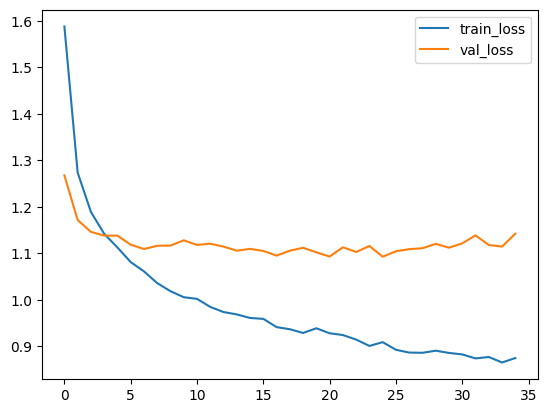

In [20]:
history_dict = history.history
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.legend()

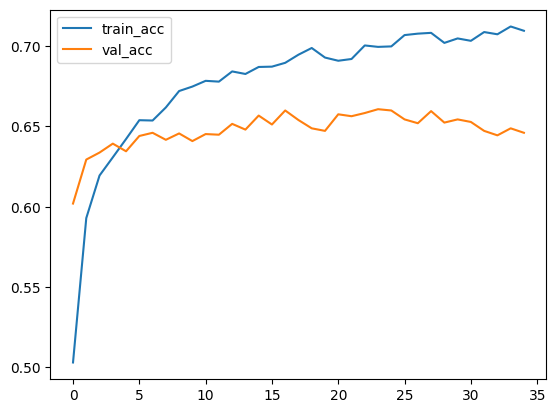

In [21]:
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.legend()

# 7| Model predictions

In [22]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [23]:
def test_predict(test_image):
    result = efficientnet_model.predict(tf.expand_dims(read_img(test_image), axis=0))
    pred_idx = int(np.argmax(result, axis=1)[0])
    pred_label = class_names[pred_idx]
    prob = float(np.max(result)) * 100
    print(f"probability: {prob:.2f}%")
    print("Predicted class :", pred_idx, f"({pred_label})")

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(pred_label)

1/1 [==============================] - 12s 12s/step
probability: 63.74%
Predicted class : 5 (clapping)


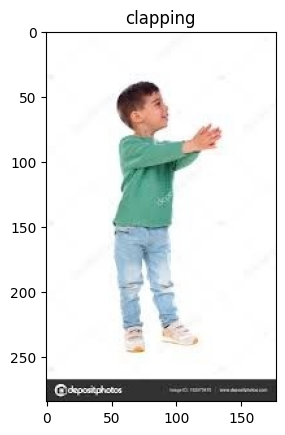

In [24]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1001.jpg")

1/1 [==============================] - 0s 134ms/step
probability: 90.33%
Predicted class : 4 (drinking)


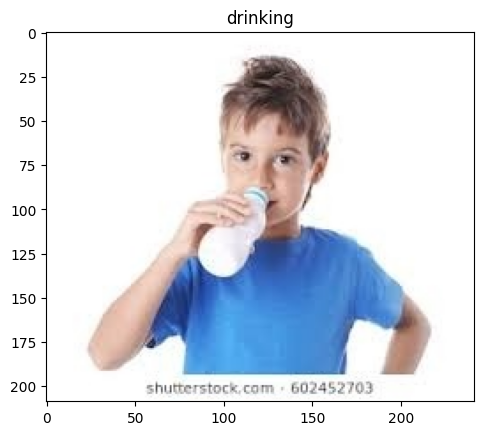

In [25]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_101.jpg")

1/1 [==============================] - 0s 136ms/step
probability: 58.86%
Predicted class : 5 (clapping)


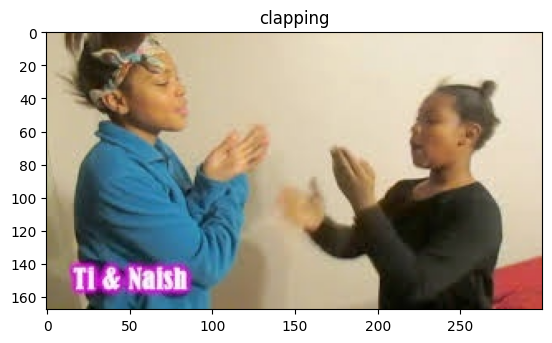

In [26]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1056.jpg")

1/1 [==============================] - 0s 139ms/step
probability: 28.43%
Predicted class : 10 (eating)


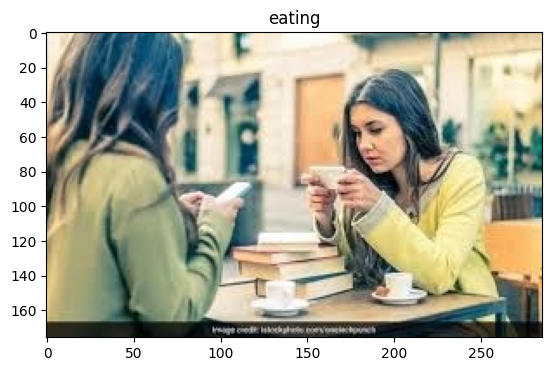

In [27]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1024.jpg")

1/1 [==============================] - 0s 139ms/step
probability: 43.49%
Predicted class : 10 (eating)


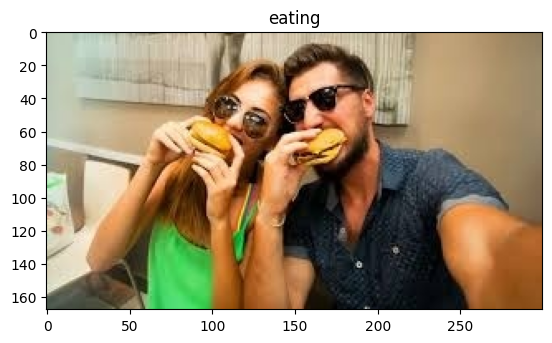

In [28]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1004.jpg")

1/1 [==============================] - 0s 140ms/step
probability: 73.94%
Predicted class : 2 (hugging)


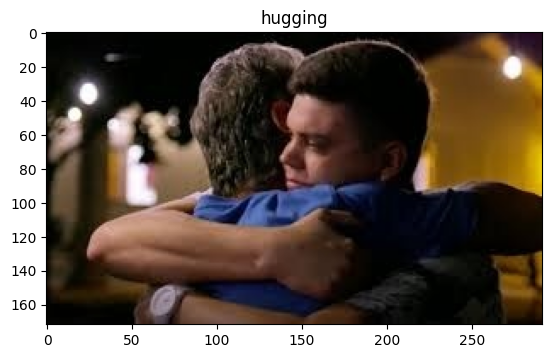

In [29]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1023.jpg")